## USGS Aquifer Selection
Code to select the 25 aquifers with the highest pumping rates <br>
Link to report: https://pubs.usgs.gov/publication/cir1464 <br>
USGS principal aquifers shapefile: https://www.sciencebase.gov/catalog/item/63140610d34e36012efa385d

In [1]:
# IMPORTS
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload
import mapclassify as mc

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

### Import aquifers, lower48, and HUC2s

In [7]:
# Aquifers to plot and dataset to use
lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
aq_usgs = gpd.read_file('ShapeFiles/Aquifers_USGS/us_aquifers.shp')
stream_network = gpd.read_file('ShapeFiles/Streams_US/us_streams.shp')
aq_usgs_selected_10 = gpd.read_file('ShapeFiles/Aquifers_USGS_10/Aquifers_USGS_10.shp')
aq_usgs_selected_25 = gpd.read_file('ShapeFiles/Aquifers_USGS_25/Aquifers_USGS_25.shp')
#huc2 = gpd.read_file('ShapeFiles/_Master_HUC2/master_huc2.shx')

### Select 10 and 25 aquifers with highest pumping rates

In [3]:
selected_aq_list_25 = ['High Plains aquifer',
                'Mississippi River Valley alluvial aquifer',
                'Central Valley aquifer system',
                'Basin and Range basin-fill aquifers',
                'Floridan aquifer system',
                'Snake River Plain basaltic-rock aquifers',
                'Coastal lowlands aquifer system',
                'California Coastal Basin aquifers', 
                'Pacific Northwest basin-fill aquifers',
                'Northern Atlantic Coastal Plain aquifer system',
                'Columbia Plateau basaltic-rock aquifers',
                'Rio Grande aquifer system',
                'Mississippi embayment aquifer system',
                'Cambrian-Ordovician aquifer system',
                'Southeastern Coastal Plain aquifer system',
                'Biscayne aquifer',
                'Edwards-Trinity aquifer system',
                'Northern Rocky Mountains Intermontane Basins aquifer system',
                'Piedmont and Blue Ridge crystalline-rock aquifers',
                'Surficial aquifer system',
                'Valley and Ridge aquifers',
                'Silurian-Devonian aquifers',
                'Pacific Northwest basaltic-rock aquifers',
                'Willamette Lowland basin-fill aquifers',
                'Lower Cretaceous aquifers']

selected_aq_list_10 = ['High Plains aquifer',
                'Mississippi River Valley alluvial aquifer',
                'Central Valley aquifer system',
                'Basin and Range basin-fill aquifers',
                'Floridan aquifer system',
                'Snake River Plain basaltic-rock aquifers',
                'Coastal lowlands aquifer system',
                'California Coastal Basin aquifers', 
                'Pacific Northwest basin-fill aquifers',
                'Northern Atlantic Coastal Plain aquifer system']

### No longer need to run cell below since shapefiles have been created

In [4]:
# aq_usgs_selected_25 = aq_usgs.loc[aq_usgs['AQ_NAME'].isin(selected_aq_list_25)]
# aq_usgs_selected_25 = aq_usgs_selected_25.dissolve(by='AQ_NAME', as_index=False)
# aq_usgs_selected_25.to_file('ShapeFiles/Aquifers_USGS_25', driver='ESRI Shapefile')

# aq_usgs_selected_10 = aq_usgs.loc[aq_usgs['AQ_NAME'].isin(selected_aq_list_10)]
# aq_usgs_selected_10 = aq_usgs_selected_10.dissolve(by='AQ_NAME', as_index=False)
# aq_usgs_selected_10.to_file('ShapeFiles/Aquifers_USGS_10', driver='ESRI Shapefile')

### Plot aquifers and lower48

In [5]:
show_huc4 = False
show_gauges = False
# True if you want to save image. Overwrite true if you want to overwrite existing image of same name
save_img = True
overwrite = True
# True if you want a context basemap (adds runtime)
basemap = False

In [8]:
aq_list_25 = aq_usgs_selected_25['AQ_NAME'].tolist()
color_names_25 = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink',
               'teal', 'lavender', 'brown', 'black', 'maroon', 'lightblue', 'coral', 'olive', 'navy', 'lightgreen',
              'turquoise', 'gold', 'skyblue', 'violet', 'salmon']
colors_by_name_25 = [mcolors.CSS4_COLORS[name] for name in color_names_25]
colors_dict_25 = dict(zip(aq_list_25, colors_by_name_25))

aq_list_10 = aq_usgs_selected_10['AQ_NAME'].tolist()
color_names_10 = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
colors_by_name_10 = [mcolors.CSS4_COLORS[name] for name in color_names_10]
colors_dict_10 = dict(zip(aq_list_10, colors_by_name_10))

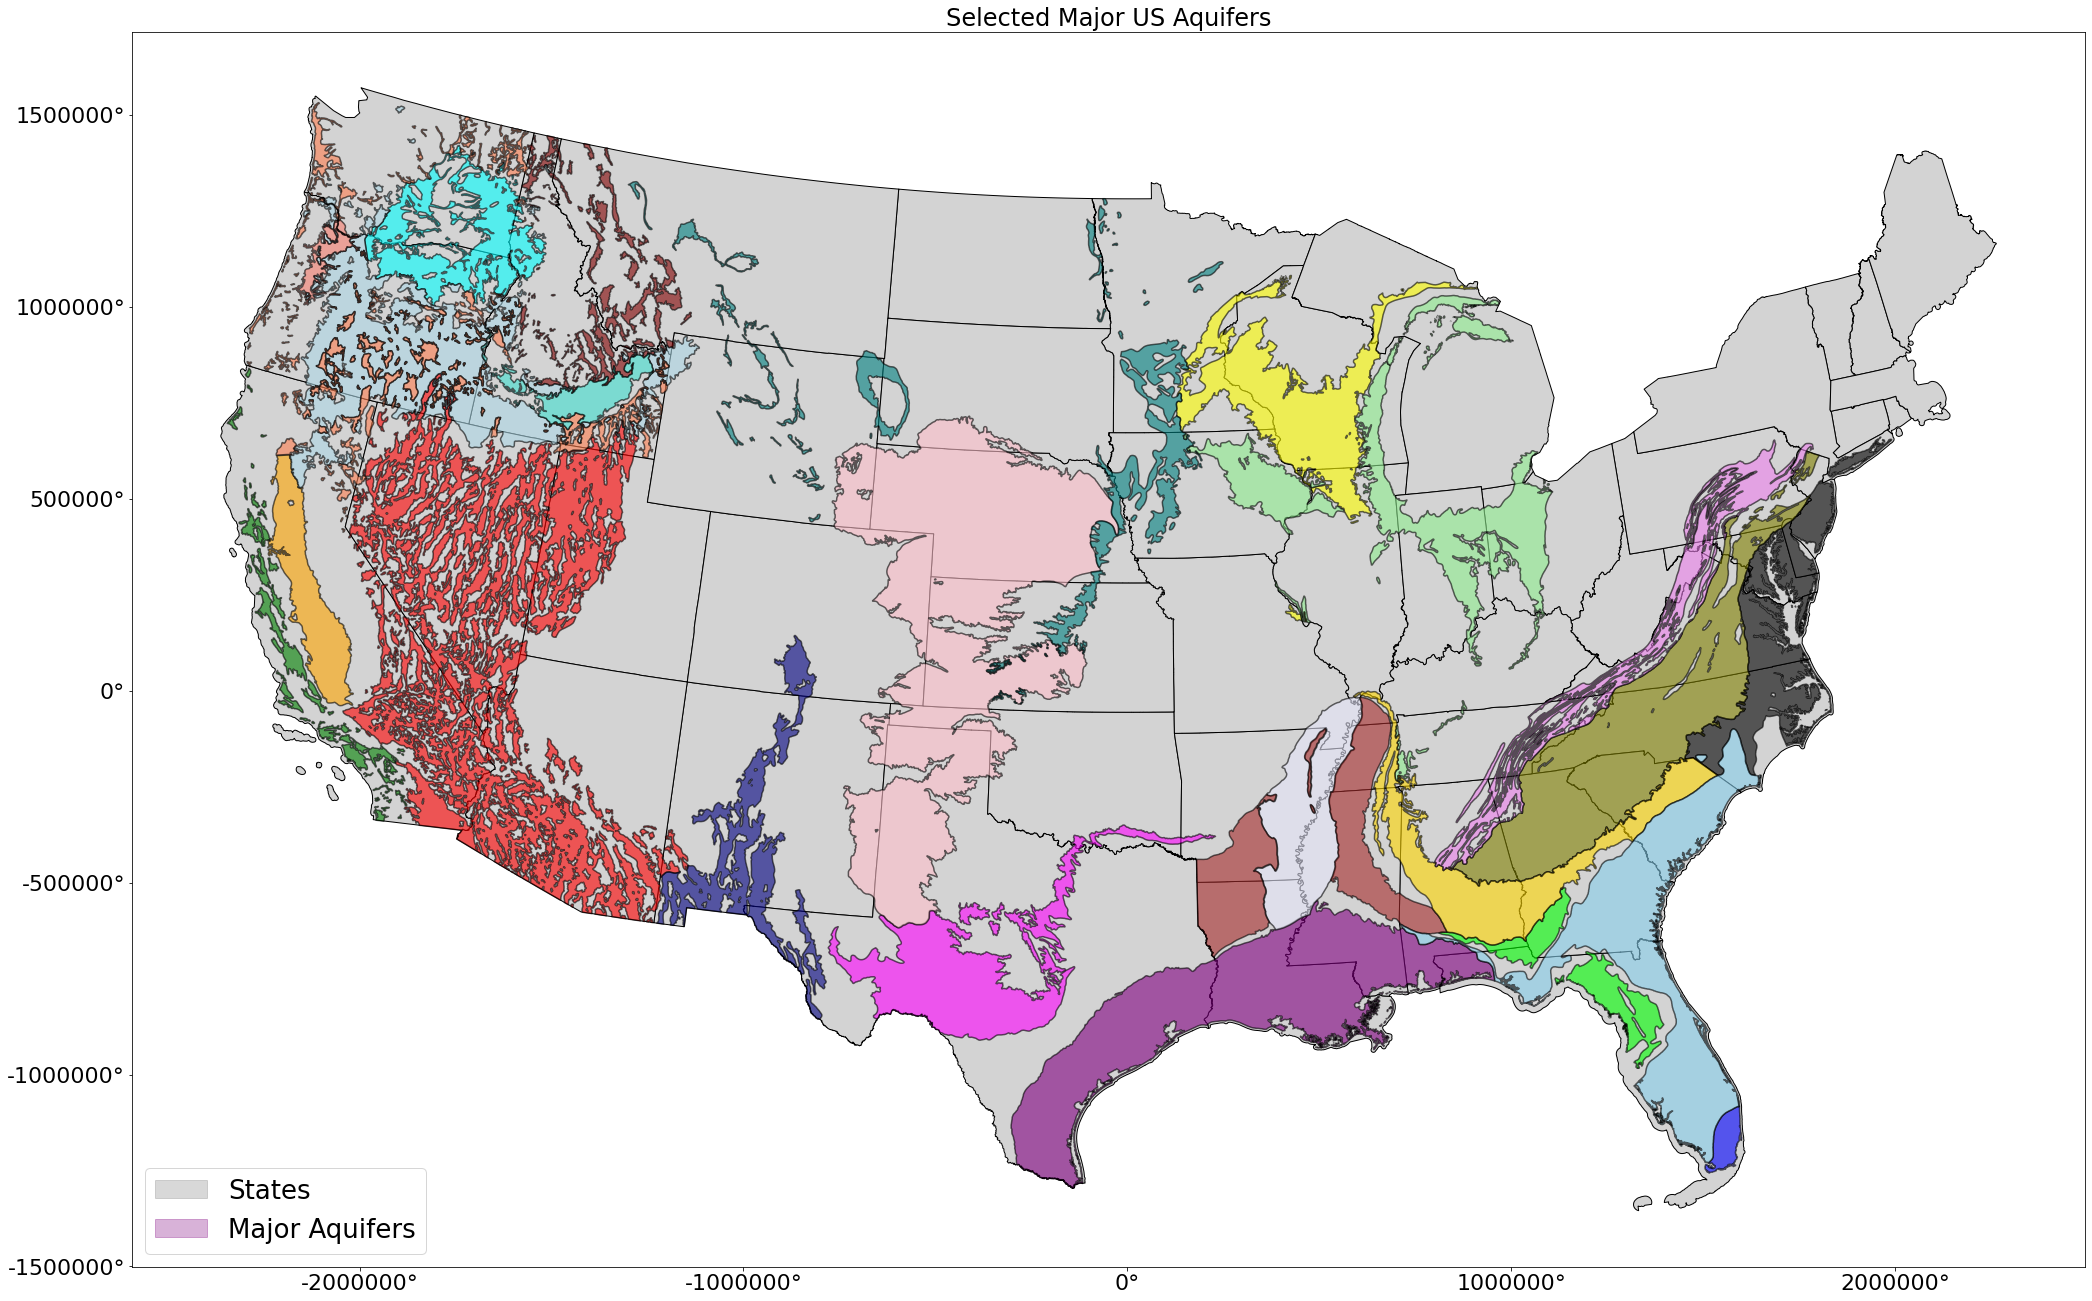

In [24]:
fig, ax = plt.subplots(figsize=(35, 35))
#plt.title(f"Multi-Aquifer {metric} Plot for {range} Years & {quantile}th Quantile", loc='center', fontsize=24)
plt.title(f'Selected Major US Aquifers', fontsize=24)

# Lower-48 Plot
if not basemap:       
    #lower48 = lower48.to_crs(epsg=4269)
    lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=1.0)  
    
# Plot counties
#counties_us = counties_us.to_crs(epsg=4269)
#counties_us = counties_us.to_crs('ESRI:102003')
#counties_plot = counties_us.plot(ax=ax, edgecolor='white', facecolor='none', alpha = 0.5, legend=True)

#aq_usgs_selected_25 = aq_usgs_selected_25.to_crs(epsg=4269)
aq_usgs_selected_25 = aq_usgs_selected_25.to_crs('ESRI:102003')
for aq, color in colors_dict_25.items():
    aq_usgs_selected_25[aq_usgs_selected_25['AQ_NAME'] == aq].plot(ax=ax, edgecolor='black', color=color, linewidth=1.5, alpha=0.6)
#aq_usgs_selected.plot(ax=ax, edgecolor='black', facecolor='purple', linewidth=1.5, alpha=0.2)

if show_huc4:
    for aq in aquifers:
        fn.plot_huc4(ax, huc4_shape, codes=aq.huc4s)
        
# Plot streams
#streams_plot = streams.plot(ax=ax, edgecolor='blue', facecolor='blue', alpha = 0.5, legend=True)

if basemap:
    fn.plot_basemap(ax)
    
# Plot legend
handles = []  # Store handles for legend
labels = []   # Store labels for legend
handles.extend([Patch(color='grey', alpha=0.3), 
                Patch(color='purple', alpha=0.3)])  # Add the handle for legend
labels.extend(['States', 'Major Aquifers'])  # Add the label for legend
#legend = ax.get_legend()
ax.legend(handles, labels, loc='lower left', fontsize=26)

ax.tick_params(axis='both', which='major', labelsize=22)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}°'.format(val)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}°'.format(val)))
#ax.axis("off")

# Save images if they don't exist or if overwrite is True
if save_img:
    img_path = f'Saved_Visuals/Aquifers/aquifer_map_25.png'
    fn.save_plot_as_image(img_path, overwrite)    

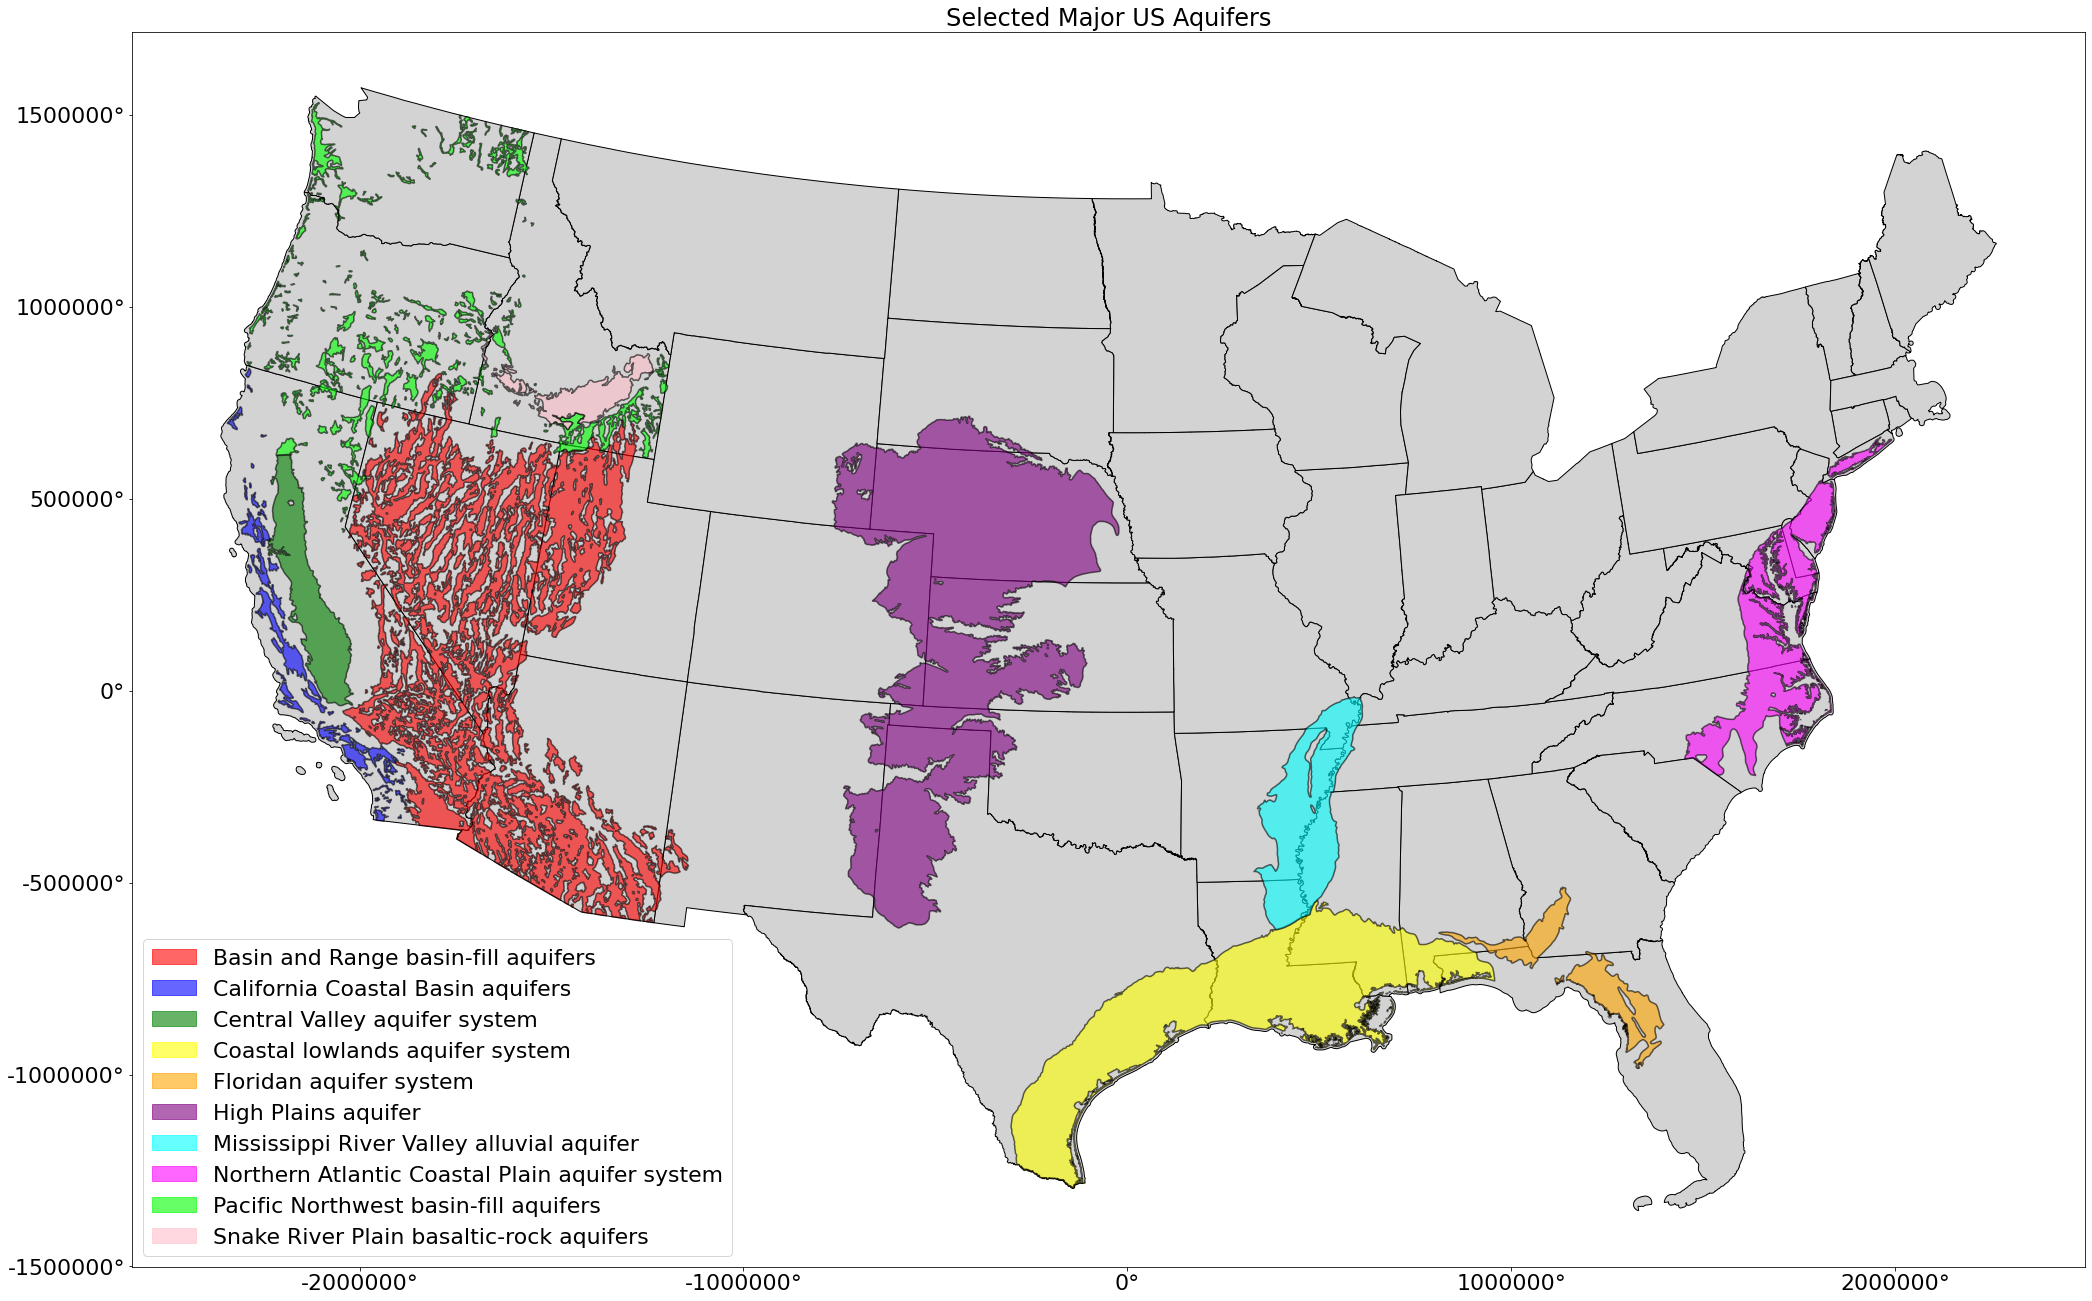

In [25]:
fig, ax = plt.subplots(figsize=(35, 35))
#plt.title(f"Multi-Aquifer {metric} Plot for {range} Years & {quantile}th Quantile", loc='center', fontsize=24)
plt.title(f'Selected Major US Aquifers', fontsize=24)

# Lower-48 Plot
if not basemap:       
    #lower48 = lower48.to_crs(epsg=4269)
    lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=1.0)  
    
#fn.plot_stream_network(stream_network, ax, zorder=2, alpha=0.70)
    
# Plot counties
#counties_us = counties_us.to_crs(epsg=4269)
#counties_us = counties_us.to_crs('ESRI:102003')
#counties_plot = counties_us.plot(ax=ax, edgecolor='white', facecolor='none', alpha = 0.5, legend=True)

#aq_usgs_selected_10 = aq_usgs_selected_25.to_crs(epsg=4269)
aq_usgs_selected_10 = aq_usgs_selected_25.to_crs('ESRI:102003')
for aq, color in colors_dict_10.items():
    aq_usgs_selected_10[aq_usgs_selected_10['AQ_NAME'] == aq].plot(ax=ax, edgecolor='black', color=color, linewidth=1.5, alpha=0.6)
#aq_usgs_selected.plot(ax=ax, edgecolor='black', facecolor='purple', linewidth=1.5, alpha=0.2)

if show_huc4:
    for aq in aquifers:
        fn.plot_huc4(ax, huc4_shape, codes=aq.huc4s)
        
# Plot streams
#streams_plot = streams.plot(ax=ax, edgecolor='blue', facecolor='blue', alpha = 0.5, legend=True)

if basemap:
    fn.plot_basemap(ax)
    
# Plot legend
handles = []  # Store handles for legend
labels = []   # Store labels for legend
handles.extend([Patch(color='red', alpha=0.6), 
                Patch(color='blue', alpha=0.6),
                Patch(color='green', alpha=0.6),
                Patch(color='yellow', alpha=0.6),
                Patch(color='orange', alpha=0.6),
                Patch(color='purple', alpha=0.6),
                Patch(color='cyan', alpha=0.6),
                Patch(color='magenta', alpha=0.6),
                Patch(color='lime', alpha=0.6),
                Patch(color='pink', alpha=0.6)])  # Add the handle for legend
labels.extend(['Basin and Range basin-fill aquifers',
               'California Coastal Basin aquifers',
               'Central Valley aquifer system',
               'Coastal lowlands aquifer system',
               'Floridan aquifer system',
               'High Plains aquifer',
               'Mississippi River Valley alluvial aquifer',
               'Northern Atlantic Coastal Plain aquifer system',
               'Pacific Northwest basin-fill aquifers',
               'Snake River Plain basaltic-rock aquifers'])  # Add the label for legend
#legend = ax.get_legend()
ax.legend(handles, labels, loc='lower left', fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=22)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}°'.format(val)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}°'.format(val)))
#ax.axis("off")

# Save images if they don't exist or if overwrite is True
if save_img:
    img_path = f'Saved_Visuals/Aquifers/aquifer_map_10.png'
    fn.save_plot_as_image(img_path, overwrite) 

In [9]:
dict(zip(aq_list_25, color_names_25))

{'Basin and Range basin-fill aquifers': 'red',
 'Biscayne aquifer': 'blue',
 'California Coastal Basin aquifers': 'green',
 'Cambrian-Ordovician aquifer system': 'yellow',
 'Central Valley aquifer system': 'orange',
 'Coastal lowlands aquifer system': 'purple',
 'Columbia Plateau basaltic-rock aquifers': 'cyan',
 'Edwards-Trinity aquifer system': 'magenta',
 'Floridan aquifer system': 'lime',
 'High Plains aquifer': 'pink',
 'Lower Cretaceous aquifers': 'teal',
 'Mississippi River Valley alluvial aquifer': 'lavender',
 'Mississippi embayment aquifer system': 'brown',
 'Northern Atlantic Coastal Plain aquifer system': 'black',
 'Northern Rocky Mountains Intermontane Basins aquifer system': 'maroon',
 'Pacific Northwest basaltic-rock aquifers': 'lightblue',
 'Pacific Northwest basin-fill aquifers': 'coral',
 'Piedmont and Blue Ridge crystalline-rock aquifers': 'olive',
 'Rio Grande aquifer system': 'navy',
 'Silurian-Devonian aquifers': 'lightgreen',
 'Snake River Plain basaltic-rock aqu

In [10]:
dict(zip(aq_list_10, color_names_10))

{'Basin and Range basin-fill aquifers': 'red',
 'California Coastal Basin aquifers': 'blue',
 'Central Valley aquifer system': 'green',
 'Coastal lowlands aquifer system': 'yellow',
 'Floridan aquifer system': 'orange',
 'High Plains aquifer': 'purple',
 'Mississippi River Valley alluvial aquifer': 'cyan',
 'Northern Atlantic Coastal Plain aquifer system': 'magenta',
 'Pacific Northwest basin-fill aquifers': 'lime',
 'Snake River Plain basaltic-rock aquifers': 'pink'}

## HUC2 Watersheds

## Import gages

In [12]:
# Dataset upload
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/National_Metrics_50_95.xlsx'    
}

dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}

In [13]:
# Valid gages
date_ranges = ['30', '50']
percentiles = ['90', '95']
dfs_valid = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        dfs_valid[f'{date_range}_{percentile}'] = dfs_metrics[f'{date_range}_{percentile}'][dfs_metrics[f'{date_range}_{percentile}']['valid'] == True]

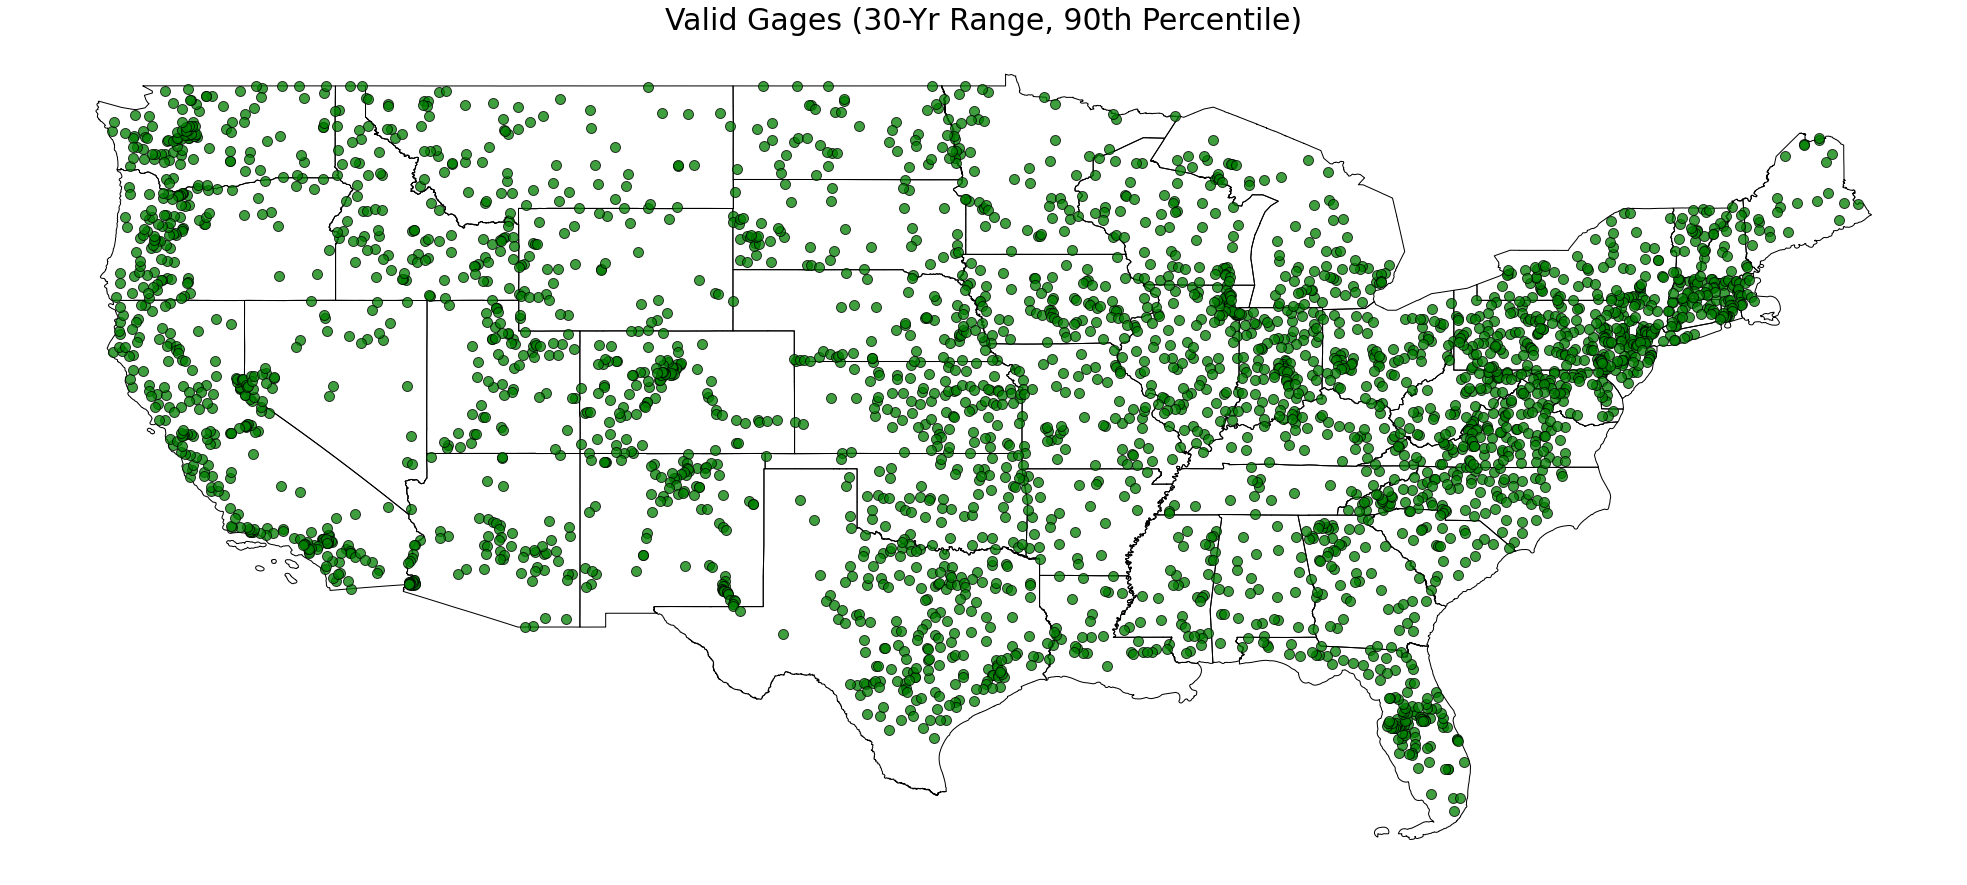

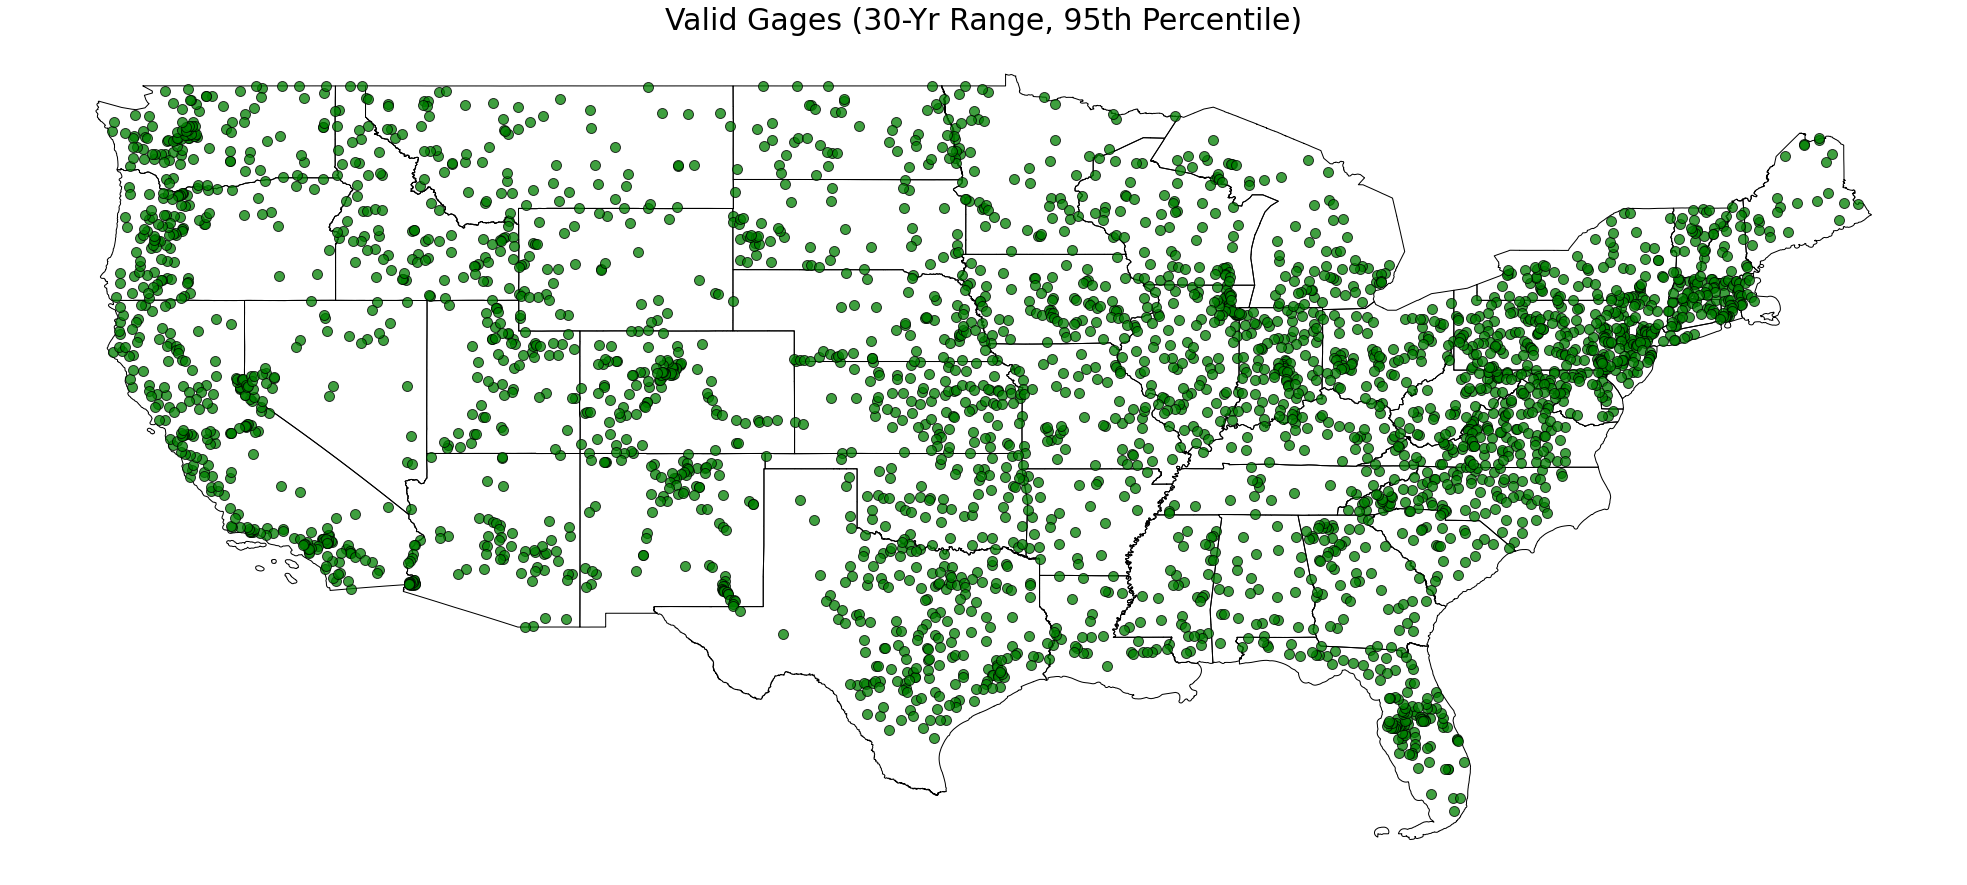

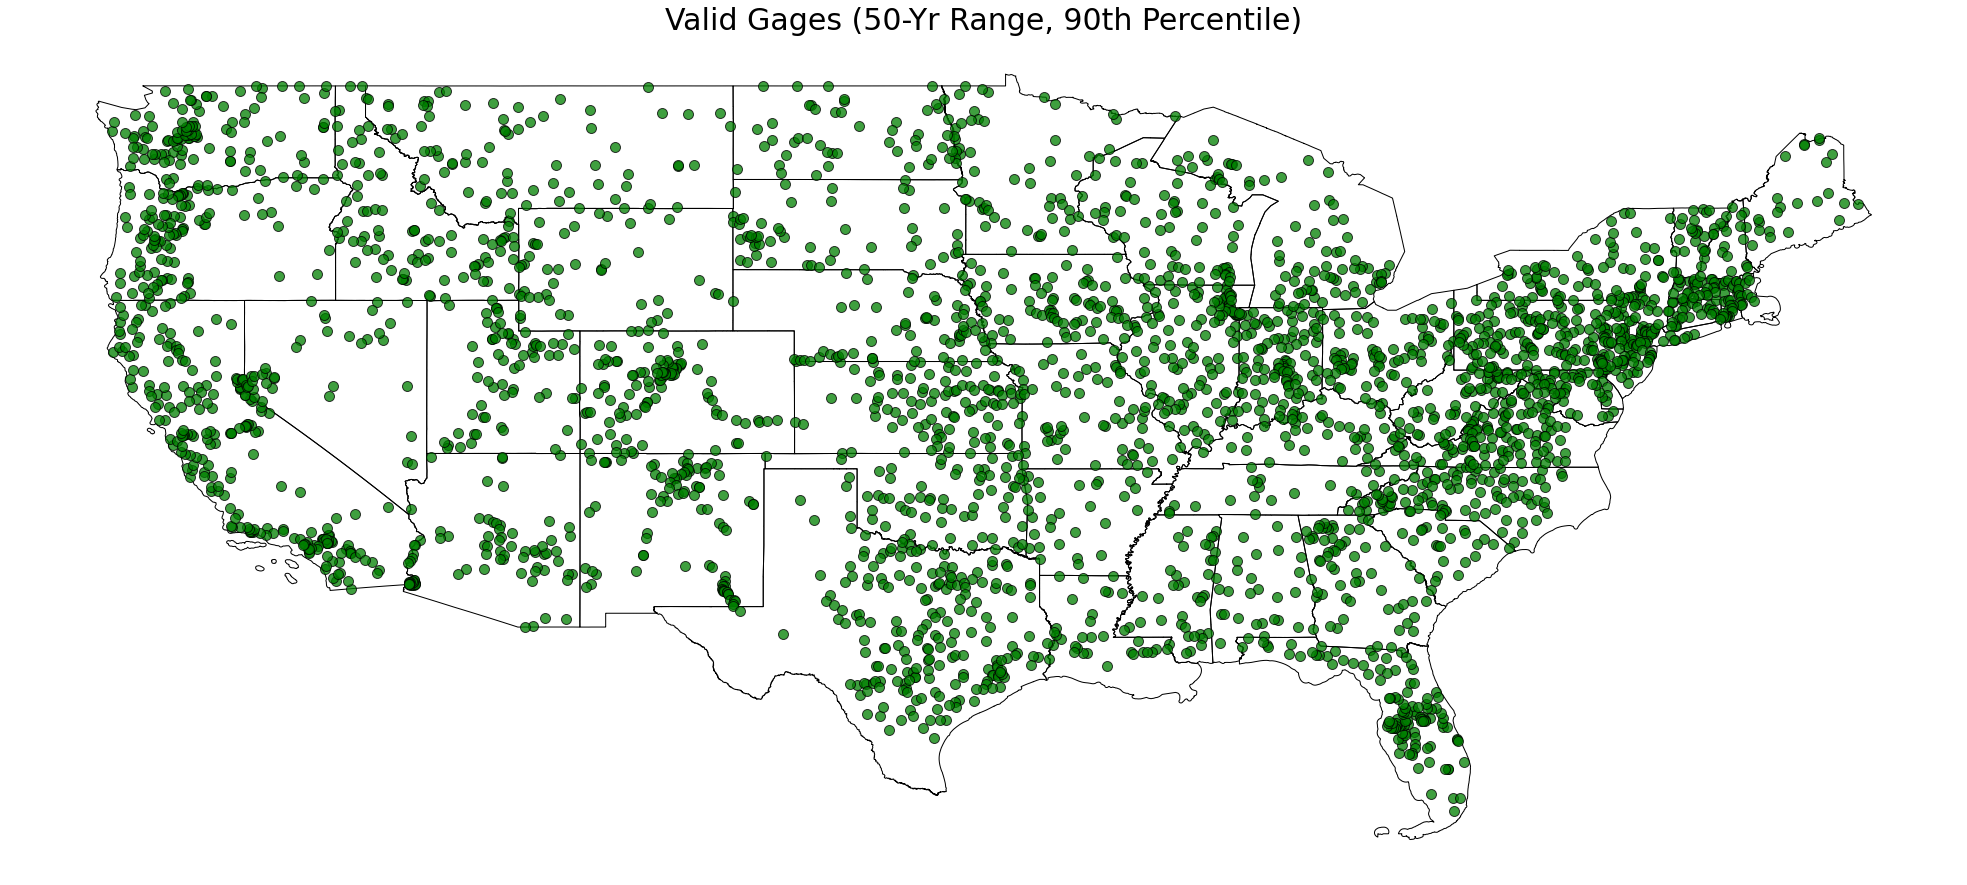

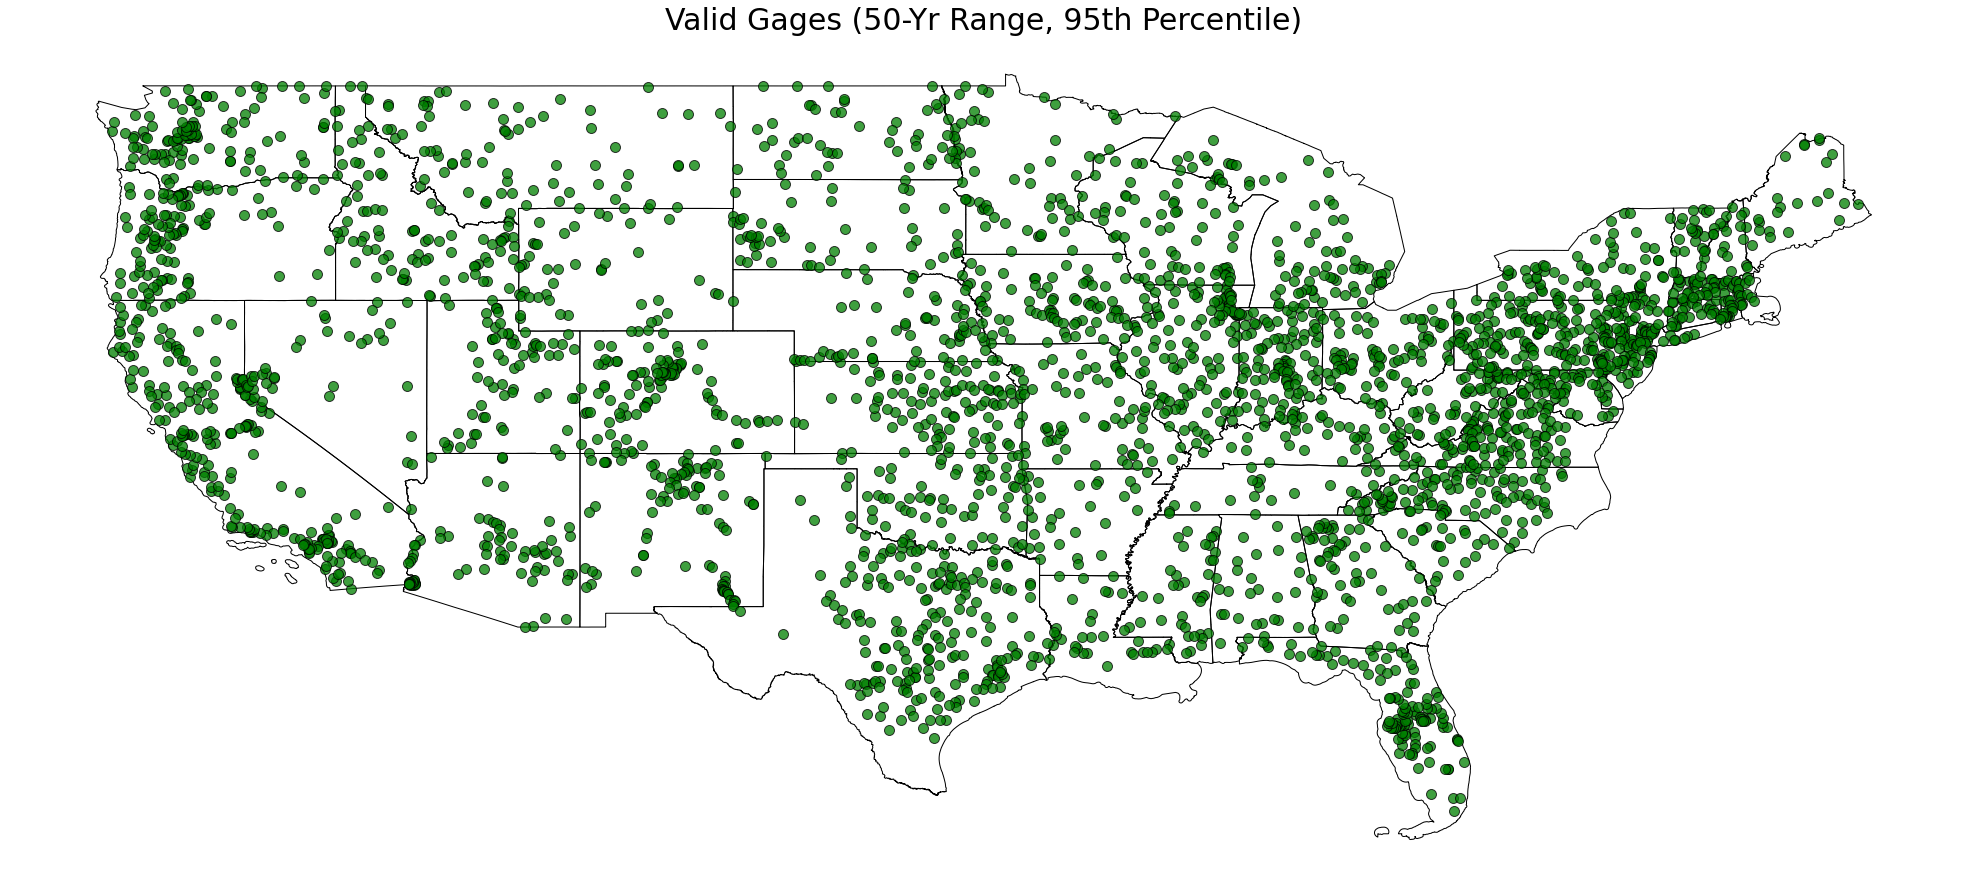

In [13]:
# Plot gages
def plot_valid_gages(date, percentile):
    df = dfs_valid[f'{date_range}_{percentile}']
    fig, ax = plt.subplots(figsize=(35, 35))
    
    plt.title(f'Valid Gages ({date}-Yr Range, {percentile}th Percentile)', fontsize=30)

    lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
    lower48 = lower48.to_crs(epsg=4269)
    #lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.0) 

    lat = df['dec_lat_va'].tolist()
    long = df['dec_long_va'].tolist()
    geometry = [Point(xy) for xy in zip(long, lat)]
    geo_pts = gpd.GeoDataFrame(geometry=geometry)

    bx = geo_pts.plot(ax=ax, color='green', marker='o', markersize=100, 
                         edgecolor='black', linewidth=1, alpha=0.75, legend=True) 

    plt.axis("off")

    plt.show()
    return
  
#df_valid_list = [df_30_90, df_50_90, df_30_95, df_50_95]
for date in date_ranges:
    for percentile in percentiles:
        plot_valid_gages(date, percentile)

## Individual Aquifers

In [14]:
aquifer_name = 'Central Valley aquifer system'

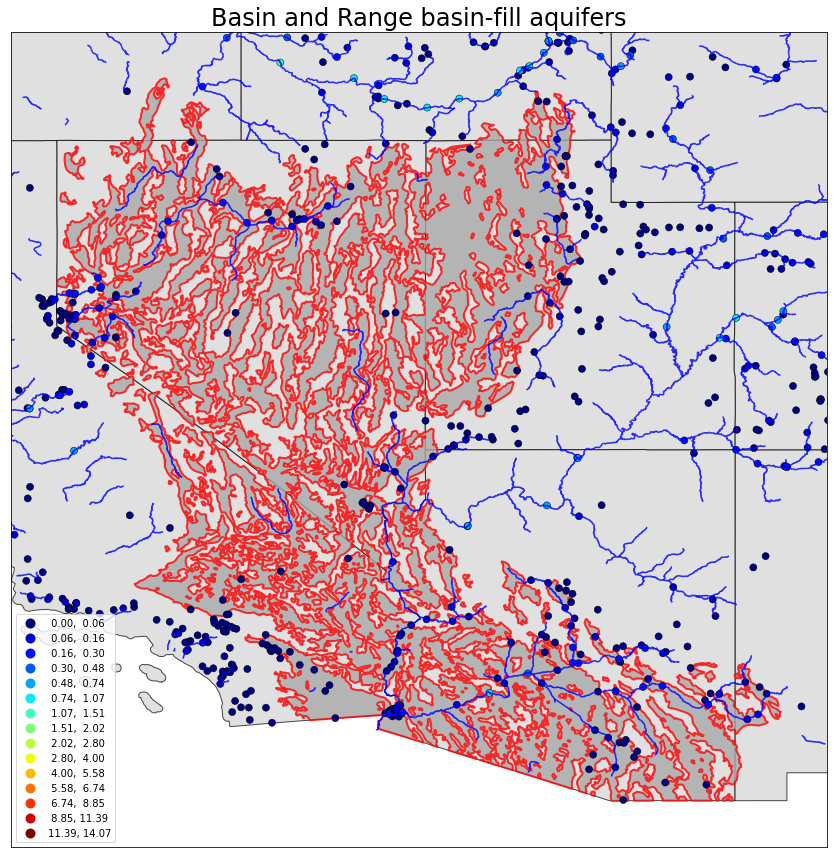

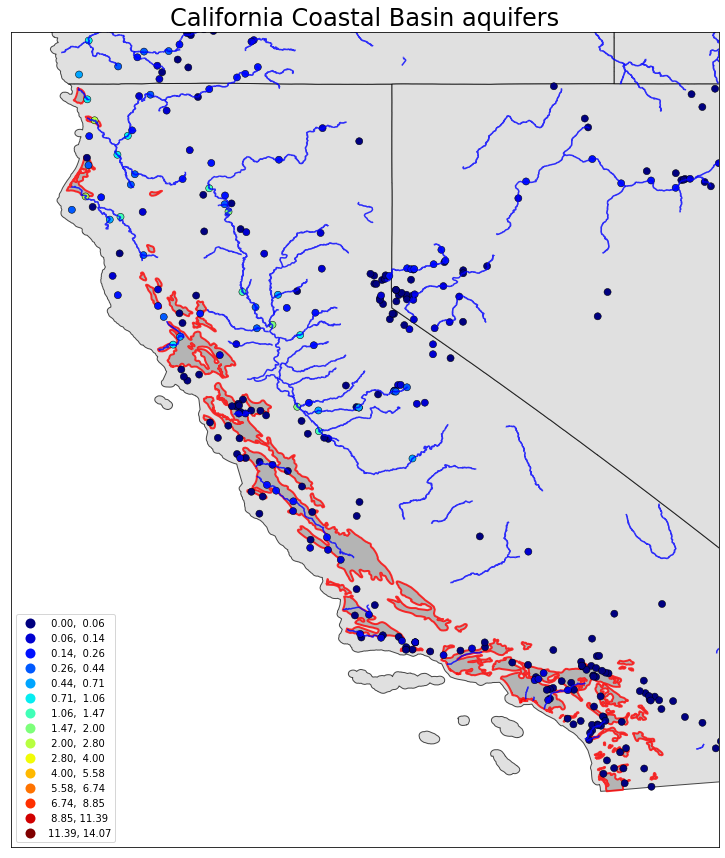

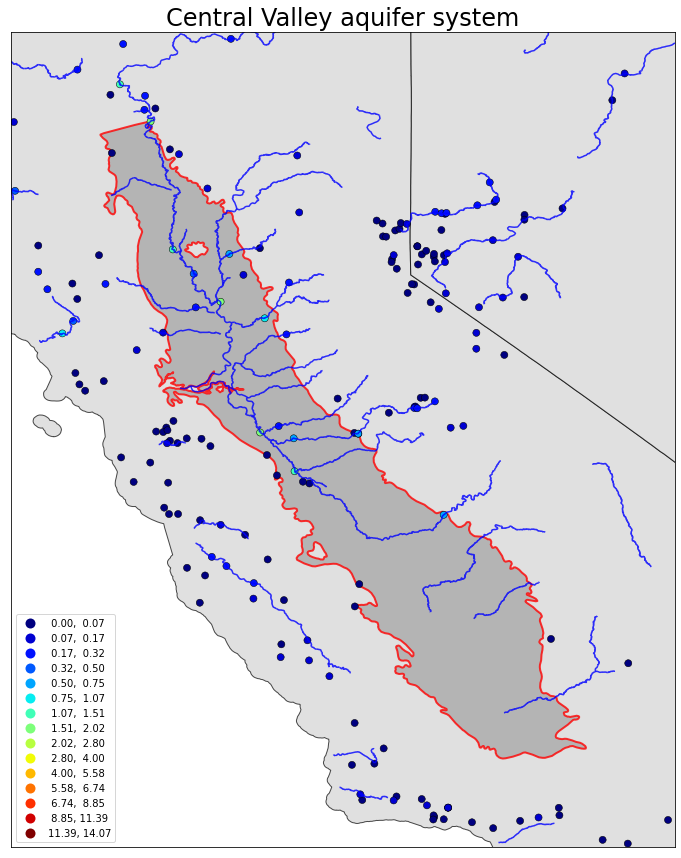

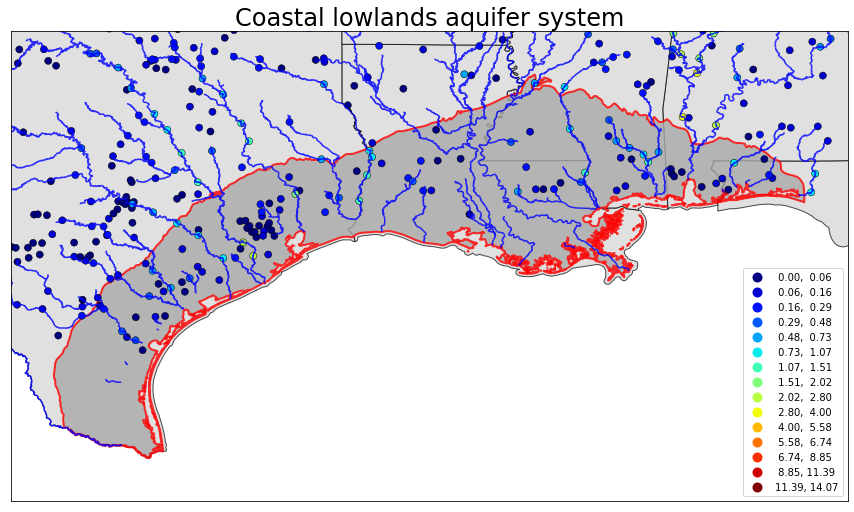

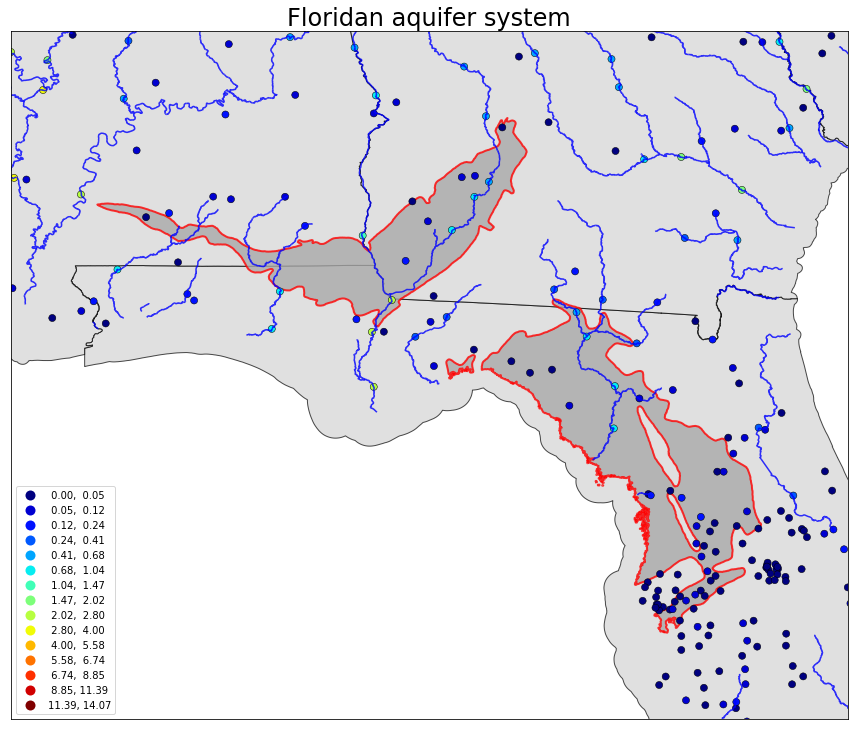

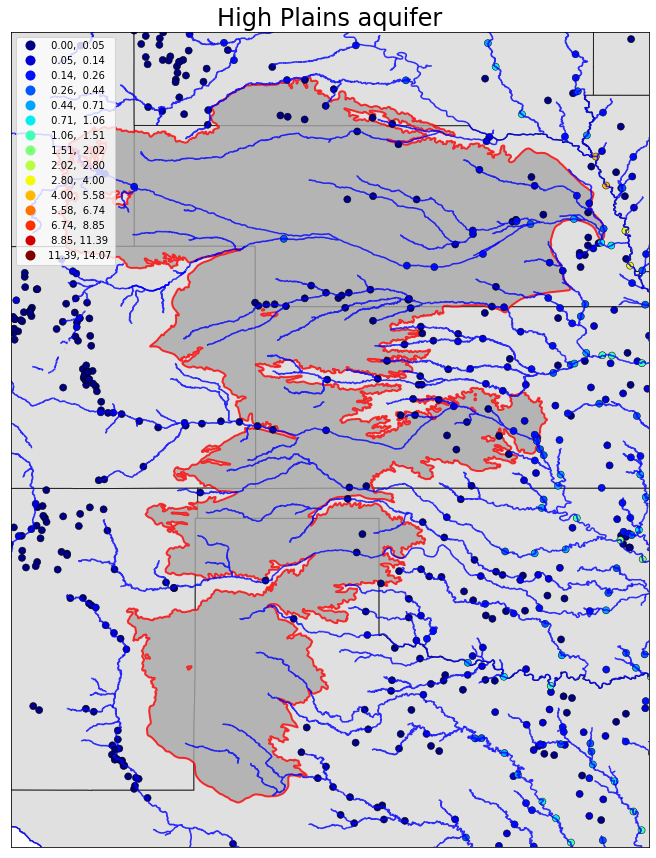

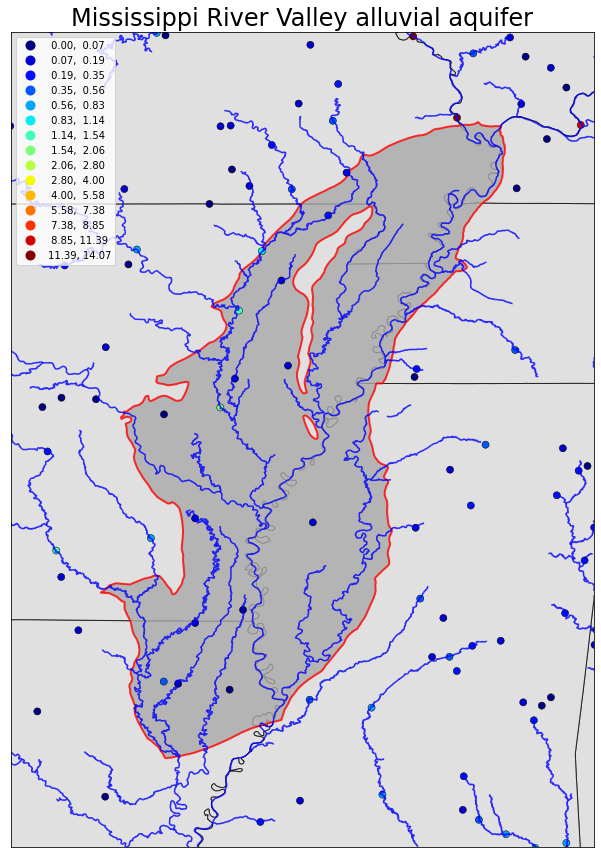

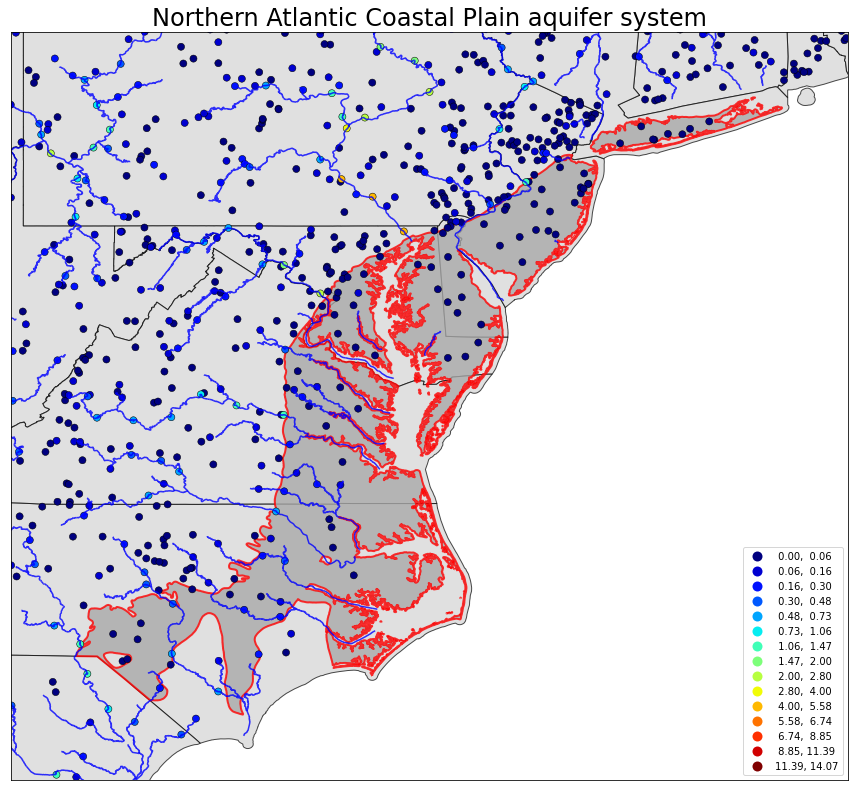

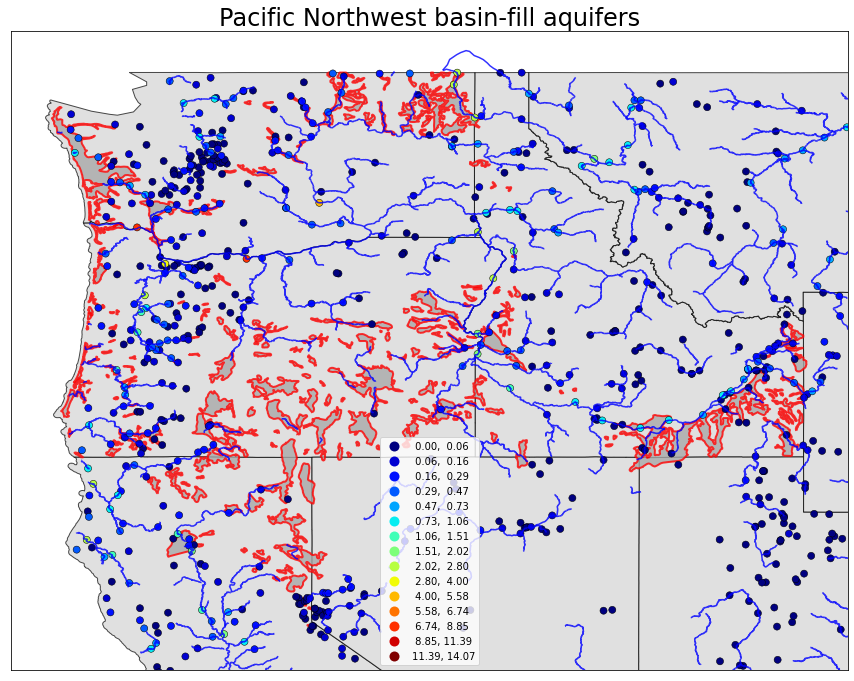

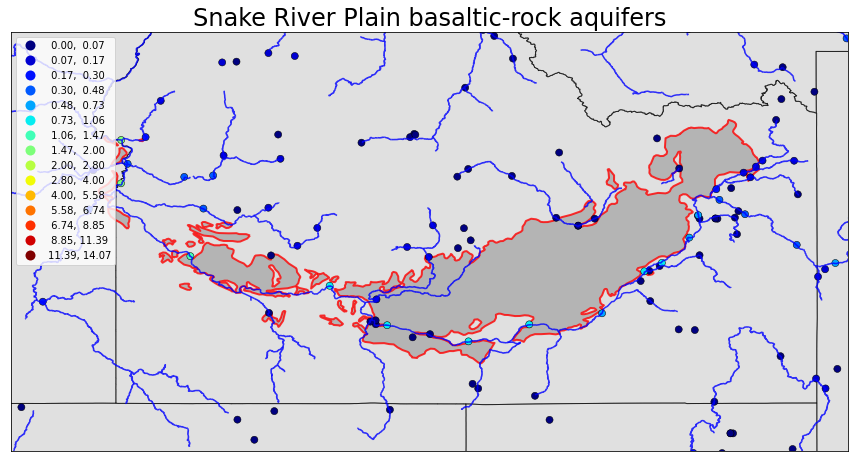

In [26]:
def plot_single_aquifer(aquifer_name, lower48, df):
    fig, ax = plt.subplots(figsize=(15, 15))
    #plt.title(f"Multi-Aquifer {metric} Plot for {range} Years & {quantile}th Quantile", loc='center', fontsize=24)
    plt.title(f'{aquifer_name}', fontsize=24)

    # Lower-48 Plot
    lower48 = lower48.to_crs(epsg=4269)
    #lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=1.0, alpha=0.7) 

    #stream_network = stream_network.to_crs(epsg=4269)
    stream_network.plot(ax=ax, color='blue', linewidth=1.5, alpha=0.8, zorder=2) 

    aq_usgs_selected_10 = aq_usgs_selected_25.to_crs(epsg=4269)
    aq_shape_1 = aq_usgs_selected_10[aq_usgs_selected_10['AQ_NAME'] == aquifer_name]
    aq_shape_1.plot(ax=ax, facecolor='darkgrey', edgecolor='red', linewidth=2.0, alpha=0.8)
    
    lat = df['dec_lat_va'].tolist()
    long = df['dec_long_va'].tolist()
    geometry = [Point(xy) for xy in zip(long, lat)]
    geo_pts = gpd.GeoDataFrame(geometry=geometry)
    df = df.reset_index()
    geo_df = geo_pts.merge(df, how='left', left_index=True, right_index=True)

    classifier = mc.NaturalBreaks(geo_df['annual_hmf'], k=15)
    geo_df = geo_df.sort_values('annual_hmf', ascending=True)

    #bx = geo_df.plot(ax=ax, color='green', marker='o', markersize=50, 
    #                     edgecolor='black', linewidth=1, alpha=0.75, legend=True) 

    cmap='jet' #'rainbow_r'
    geo_df.plot(ax=ax, column='annual_hmf', scheme='user_defined', classification_kwds={'bins': classifier.bins}, 
                cmap=cmap, legend=True, #legend_kwds=legend_frmt, 
                alpha=1.0, marker='o', 
                markersize=50,
                edgecolor='black', linewidth=0.5)

    #xmin, xmax, ymin, ymax = fn.set_plot_bounds(aq_shape_1, padding=30.0)

    xmin, ymin, xmax, ymax = aq_shape_1.total_bounds
    padding = 0.75
    xmin -= padding
    ymin -= padding
    xmax += padding
    ymax += padding

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([])
    ax.set_xticks([])
    
    img_path = f'Saved_Visuals/Aquifers/{aquifer_name}_gages.png'
    fn.save_plot_as_image(img_path, overwrite) 

    plt.show()
    
for aquifer_name in aq_list_10:
    plot_single_aquifer(aquifer_name, lower48, dfs_valid['30_90'])
#plot_single_aquifer(aquifer_name, lower48)

In [34]:
# import plotly.express as px

# df_1 = dfs_valid['30_90']

# # The metric to color the datapoints by
# color_metric = "inter_annual%"
# # The metric to size the datapoints by
# size_metric = "annual_hmf"

# df_1 = df_1.sort_values(by=size_metric, ascending=True)

# fig = px.scatter_mapbox(df_1, lat="dec_lat_va", lon="dec_long_va", hover_name='site_no', hover_data=["site_no", "annual_hmf"], color=size_metric,
#                        zoom=3, height=700, width=1200, color_continuous_scale=px.colors.sequential.Rainbow, opacity=0.75)

# # fig.add_trace(px.choropleth_mapbox(aq_usgs_selected_10, 
# #                                     geojson=aq_usgs_selected_10.geometry, 
# #                                     #locations=aq_usgs_selected_10.index, 
# #                                     color='Shape_Area', 
# #                                     hover_name='AQ_NAME').data[0])

# # aq_usgs_selected_10 = aq_usgs_selected_25.to_crs(epsg=4269)
# # fig = px.choropleth_mapbox(aq_usgs_selected_10, 
# #                             geojson=aq_usgs_selected_10.geometry, 
# #                             color='Shape_Area',
# #                             #locations=aq_usgs_selected_10.index,
# #                             hover_name='AQ_NAME')
              
# # fig = px.choropleth(aq_usgs_selected_10,
# #                    geojson=aq_usgs_selected_10.geometry,
# #                    locations=aq_usgs_selected_10.index,
# #                    color="Shape_Area")
# #                    #projection="mercator")

# # aq_usgs_selected_10 = aq_usgs_selected_25.to_crs(epsg=4269)
# # aq_shape_1 = aq_usgs_selected_10[aq_usgs_selected_10['AQ_NAME'] == aquifer_name]
# # aq_shape_1.plot(ax=ax, facecolor='darkgrey', edgecolor='red', linewidth=2.0, alpha=0.8)

# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.update_geos(fitbounds="locations", visible=False)
# fig.show()

In [45]:
# Outlet gages by aquifer
br_outlet_gages = ['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
cc_outlet_gages = ['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
cv_outlet_gages = ['11303500', '11447650']
cl_outlet_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500',
      '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
fl_outlet_gages = ['02368000', '02365500', '02358000', '02320500', '02313230']
hp_outlet_gages = ['08123800', '08121000', '07297910', '07228000', '07234000', '07157500', '07144550', '06853500', '06805500', '06799500', '06465500']
mr_outlet_gages = ['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
na_outlet_gages = ['02105769', '02089500', '02091500', '02083500',  '02085000', '02052000', '02047000', '02049500',  '02041650', '02037500', '01668000', 
      '01673000',  '01646500', '01578310', '01474500',  '01463500']
pn_outlet_gages = ['11039800', '12200500', '12040500', '14211720',  '14372300']
sr_outlet_gages = ['13269000']

outlet_gages_dict = {
    'br': br_outlet_gages, 
    'cc': cc_outlet_gages,
    'cv': cv_outlet_gages,
    'cl': cl_outlet_gages,
    'fl': fl_outlet_gages,
    'hp': hp_outlet_gages,
    'mr': mr_outlet_gages,
    'na': na_outlet_gages,
    'pn': pn_outlet_gages,
    'sr': sr_outlet_gages
}

In [40]:
df_30_90 =dfs_valid['30_90']
df_30_90

site_no analyze_start analyze_end  analyze_range  quantile  valid  \
1      2342500    1990-10-01  2020-09-30             30       0.9   True   
2      2361000    1990-10-01  2020-09-30             30       0.9   True   
4      2363000    1990-10-01  2020-09-30             30       0.9   True   
6      2369800    1990-10-01  2020-09-30             30       0.9   True   
7      2371500    1990-10-01  2020-09-30             30       0.9   True   
...        ...           ...         ...            ...       ...    ...   
7838   9211200    1990-10-01  2020-09-30             30       0.9   True   
7841   9217000    1990-10-01  2020-09-30             30       0.9   True   
7845   9223000    1990-10-01  2020-09-30             30       0.9   True   
7846   9224700    1990-10-01  2020-09-30             30       0.9   True   
7856  13018300    1990-10-01  2020-09-30             30       0.9   True   

      missing_data%  threshold  hmf_years  annual_hmf  ...  dec_lat_va  \
1                 0     850.30         30    0.109441  ...   32.316815   
2                 0    1770.00         30    0.155185  ...   31.342949   
4                 0    1300.00         30    0.114796  ...   31.594887   
6                 0     261.00         29    0.027931  ...   31.027680   
7                 0    1380.00         30    0.117638  ...   31.573495   
...             ...        ...        ...         ...  ...         ...   
7838              0    2410.00         22    0.330262  ...   42.020972   
7841              0    2440.00         22    0.332683  ...   41.516354   
7845              0     255.00         29    0.021793  ...   42.110889   
7846              0     657.30         26    0.075912  ...   41.546072   
7856              0      29.93         28    0.002070  ...   43.452153   

      dec_long_va  data_start   data_end  total_record  state  huc2_code  \
1      -85.014931  1946-10-01 2020-09-30          74.0     AL          3   
2      -85.610491  1921-12-01 2020-09-30          98.8     AL          3   
4      -85.782997  1938-10-01 2020-09-30          82.0     AL          3   
6      -86.709957  1967-10-01 2020-09-30          53.0     AL          3   
7      -86.251623  1937-10-01 2020-09-30          83.0     AL          3   
...           ...         ...        ...           ...    ...        ...   
7838  -110.049806  1963-12-01 2020-09-30          56.8     WY         14   
7841  -109.449023  1951-10-01 2020-09-30          69.0     WY         14   
7845  -110.709417  1952-10-01 2020-09-30          68.0     WY         14   
7846  -109.693475  1962-06-01 2020-09-30          58.3     WY         14   
7856  -110.704091  1962-07-01 2020-09-30          58.3     WY         17   

      huc4_code       within_aq  HCDN_2009  
1           313             NaN      False  
2           314             NaN      False  
4           314             NaN      False  
6           314             NaN      False  
7           314             NaN      False  
...         ...             ...        ...  
7838       1404  Upper_Colorado      False  
7841       1404  Upper_Colorado      False  
7845       1404  Upper_Colorado      False  
7846       1404  Upper_Colorado      False  
7856       1704             NaN       True  

[4241 rows x 40 columns]

In [46]:
df_outlet_gages = {}
for key, value in outlet_gages_dict.items():
    df_outlet_gages[key] = df_30_90[df_30_90['site_no'].isin(value)]

In [47]:
df_outlet_gages

{'br':        site_no analyze_start analyze_end  analyze_range  quantile  valid  \
 190    9468500    1990-10-01  2020-09-30             30       0.9   True   
 276    9519800    1990-10-01  2020-09-30             30       0.9   True   
 278    9520500    1990-10-01  2020-09-30             30       0.9   True   
 310    9423000    1990-10-01  2020-09-30             30       0.9   True   
 317    9429600    1990-10-01  2020-09-30             30       0.9   True   
 318    9521100    1990-10-01  2020-09-30             30       0.9   True   
 4367  10311400    1990-10-01  2020-09-30             30       0.9   True   
 4398  10327500    1990-10-01  2020-09-30             30       0.9   True   
 4424  10351650    1993-09-01  2020-09-30             28       0.9   True   
 
       missing_data%  threshold  hmf_years  annual_hmf  ...  dec_lat_va  \
 190               0      52.03         29    0.042054  ...   33.296447   
 276               0      93.00          8    1.063235  ...   33.075046 